### creatinga DNN with five hidden layers of 100 neuron each

In [1]:

import tensorflow as tf
import numpy as np

def reset_graph():
    tf.reset_default_graph()
    tf.set_random_seed(42)
    np.random.seed(42)
    

In [2]:
# reset_graph()

# n_inputs =28*28
# n_hidden1 = 300
# n_hidden2 = 150
# n_hidden3 = 50
# n_outputs = 10

# X = tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")
# y = tf.placeholder(tf.int32, shape=(None),name="y")

# def elu(z, alpha=1):
#     return np.where(z<0, alpha * (np.exp(z) - 1), z)

# with tf.name_scope("dnn"):
#     hidden1= tf.layers.dense(X, n_hidden1,activation=tf.nn.elu,name="hidden1")
#     hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, name="hidden2")
#     hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.elu,name="hidden3")
#     logits = tf.layers.dense(hidden3, n_outputs, name="outputs"
#                             )

# with tf.name_scope("loss"):
#     xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
#     loss = tf.reduce_mean(xentropy, name="loss")

# learning_rate = 0.01
# with tf.name_scope("train"):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#     training_op = optimizer.minimize(loss)
                   
# with tf.name_scope("eval"):
#     correct = tf.nn.in_top_k(logits,y, 1)
#     print("correct:",correct)
#     accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
    
# init = tf.global_variables_initializer()
# saver = tf.train.Saver()
# n_epochs = 40
# batch_size = 50

In [2]:
# loading the dataset tf.examples.tutorials.mnist is depreciated

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1,28 *28)/ 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28)/ 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [3]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [4]:
n_inputs = 28 * 28
n_outputs = 5
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32,shape=(None),name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

W0602 18:56:34.103835 10444 deprecation.py:323] From <ipython-input-3-86c47305b780>:9: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
W0602 18:56:34.113805 10444 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\layers\core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


### using adam optimization for early stopping,on digits 0 to 3 and then using transfer for 5 to 0
### need softmaxwith 5 nerons
### make checkpoints and so tha we can resuse the mdoel later


In [6]:

learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct =tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [7]:
# creating th training set validation and teseting set
# the validation needs toimpolement early stopping

X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1  = X_test[y_test < 5]
y_test1 = y_test[y_test < 5] 

In [8]:
n_epochs = 1000
batch_size =20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx,len(X_train1)//batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        loss_val, acc_val = sess.run([loss,accuracy], feed_dict={X:X_valid1, y:y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else :
            checks_without_progress +=1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping")
                break
        print(epoch,"current loss: ", loss_val, "best loss:", best_loss, acc_val * 100)
with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X:X_test1, y:y_test1})
    print("Final accuracy:", acc_test * 100)

0 current loss:  0.122529425 best loss: 0.122529425 96.79437279701233
1 current loss:  0.16210127 best loss: 0.122529425 96.44253253936768
2 current loss:  0.10851233 best loss: 0.10851233 97.38076329231262
3 current loss:  0.08987865 best loss: 0.08987865 97.92807102203369
4 current loss:  0.16509594 best loss: 0.08987865 96.48162722587585
5 current loss:  0.13795923 best loss: 0.08987865 97.49804735183716
6 current loss:  0.11189643 best loss: 0.08987865 97.53713607788086
7 current loss:  0.13033368 best loss: 0.08987865 97.26348519325256
8 current loss:  0.61058503 best loss: 0.08987865 78.34245562553406
9 current loss:  0.32254657 best loss: 0.08987865 97.10711240768433
10 current loss:  0.8121211 best loss: 0.08987865 92.2204852104187
11 current loss:  1.3631334 best loss: 0.08987865 34.362784028053284
12 current loss:  1.379614 best loss: 0.08987865 38.154807686805725
13 current loss:  1.3626913 best loss: 0.08987865 35.37920117378235
14 current loss:  1.5563793 best loss: 0.0898

### TUning a hyperparameter using cross validation to see what precision we can achieve

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    # creates instance variables
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None
    
    # builds themodel
    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None
        
        # calls _dnn
        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)
    
    # creates graph , starts a session and trains the model
    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        #call build graph
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self
    
    # for class probabilities
    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})
    
    #calls predict_proba and returns call with highest probability
    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

In [13]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.280107	Best loss: 0.280107	Accuracy: 96.48%
1	Validation loss: 0.118016	Best loss: 0.118016	Accuracy: 97.42%
2	Validation loss: 0.080707	Best loss: 0.080707	Accuracy: 98.20%
3	Validation loss: 0.848953	Best loss: 0.080707	Accuracy: 59.81%
4	Validation loss: 0.304597	Best loss: 0.080707	Accuracy: 96.29%
5	Validation loss: 0.187342	Best loss: 0.080707	Accuracy: 96.13%
6	Validation loss: 0.155130	Best loss: 0.080707	Accuracy: 96.52%
7	Validation loss: 0.153502	Best loss: 0.080707	Accuracy: 96.99%
8	Validation loss: 0.197112	Best loss: 0.080707	Accuracy: 97.54%
9	Validation loss: 0.144216	Best loss: 0.080707	Accuracy: 97.26%
10	Validation loss: 0.130412	Best loss: 0.080707	Accuracy: 97.65%
11	Validation loss: 0.146358	Best loss: 0.080707	Accuracy: 97.54%
12	Validation loss: 0.189571	Best loss: 0.080707	Accuracy: 95.97%
13	Validation loss: 0.215957	Best loss: 0.080707	Accuracy: 96.48%
14	Validation loss: 0.128848	Best loss: 0.080707	Accuracy: 98.08%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x0000026E36A4F0D8>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000026E3B1FD248>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [15]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9838489978595057

In [21]:
def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu


In [17]:
from sklearn.model_selection import RandomizedSearchCV


param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                cv=3, random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x0000026E36A4F0D8> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.286659	Best loss: 0.286659	Accuracy: 93.24%
1	Validation loss: 0.123074	Best loss: 0.123074	Accuracy: 97.30%
2	Validation loss: 0.120591	Best loss: 0.120591	Accuracy: 97.07%
3	Validation loss: 0.127779	Best loss: 0.120591	Accuracy: 96.91%
4	Validation loss: 0.106498	Best loss: 0.106498	Accuracy: 97.19%
5	Validation loss: 0.132649	Best loss: 0.106498	Accuracy: 96.76%
6	Validation loss: 0.216658	Best loss: 0.106498	Accuracy: 94.18%
7	Validation loss: 0.118795	Best loss: 0.106498	Accuracy: 96.72%
8	Validation loss: 0.104600	Best loss: 0.104600	Accuracy: 97.42%
9	Validation loss: 0.127365	Best loss: 0.104600	Accuracy: 96.48%
10	Validation loss: 0.162556	Best loss: 0.104600	Accuracy: 96.72%
11	Validation loss: 0.156763	Best loss: 0.104600	Accuracy: 96.36%
12	Validation loss: 0.189163	Best loss: 0.104600	Accuracy: 95.97%
13	Validation loss: 1.732670	Best loss: 0.104600	Accuracy: 18.73%
14	Validation loss: 1.621623	Best loss: 0.104600	Accuracy: 20.91%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s


0	Validation loss: 0.185568	Best loss: 0.185568	Accuracy: 95.74%
1	Validation loss: 0.139123	Best loss: 0.139123	Accuracy: 97.11%
2	Validation loss: 0.139343	Best loss: 0.139123	Accuracy: 96.64%
3	Validation loss: 0.187580	Best loss: 0.139123	Accuracy: 96.25%
4	Validation loss: 1.337599	Best loss: 0.139123	Accuracy: 35.89%
5	Validation loss: 1.226708	Best loss: 0.139123	Accuracy: 43.90%
6	Validation loss: 0.794379	Best loss: 0.139123	Accuracy: 63.02%
7	Validation loss: 0.927424	Best loss: 0.139123	Accuracy: 62.63%
8	Validation loss: 0.427080	Best loss: 0.139123	Accuracy: 82.64%
9	Validation loss: 0.378933	Best loss: 0.139123	Accuracy: 87.84%
10	Validation loss: 0.438344	Best loss: 0.139123	Accuracy: 87.84%
11	Validation loss: 0.302510	Best loss: 0.139123	Accuracy: 92.34%
12	Validation loss: 0.294068	Best loss: 0.139123	Accuracy: 92.61%
13	Validation loss: 0.305502	Best loss: 0.139123	Accuracy: 93.67%
14	Validation loss: 0.296342	Best loss: 0.139123	Accuracy: 93.16%
15	Validation loss: 

30	Validation loss: 0.098435	Best loss: 0.052966	Accuracy: 98.36%
31	Validation loss: 0.075361	Best loss: 0.052966	Accuracy: 98.75%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=500, activation=<function relu at 0x0000026E36A9C1F8>, total=   4.4s
[CV] n_neurons=30, learning_rate=0.02, batch_size=500, activation=<function relu at 0x0000026E36A9C1F8> 
0	Validation loss: 0.101571	Best loss: 0.101571	Accuracy: 96.79%
1	Validation loss: 0.077615	Best loss: 0.077615	Accuracy: 97.97%
2	Validation loss: 0.060394	Best loss: 0.060394	Accuracy: 98.05%
3	Validation loss: 0.069809	Best loss: 0.060394	Accuracy: 97.97%
4	Validation loss: 0.047248	Best loss: 0.047248	Accuracy: 98.59%
5	Validation loss: 0.063869	Best loss: 0.047248	Accuracy: 97.81%
6	Validation loss: 0.054176	Best loss: 0.047248	Accuracy: 98.28%
7	Validation loss: 0.062449	Best loss: 0.047248	Accuracy: 98.48%
8	Validation loss: 0.048707	Best loss: 0.047248	Accuracy: 98.48%
9	Validation loss: 0.060607	Best loss: 0.0

W0602 10:11:48.090950 19324 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0	Validation loss: 2.510926	Best loss: 2.510926	Accuracy: 54.89%
1	Validation loss: 0.600595	Best loss: 0.600595	Accuracy: 81.59%
2	Validation loss: 0.340964	Best loss: 0.340964	Accuracy: 90.77%
3	Validation loss: 55.844013	Best loss: 0.340964	Accuracy: 49.57%
4	Validation loss: 64.609306	Best loss: 0.340964	Accuracy: 48.51%
5	Validation loss: 49.007706	Best loss: 0.340964	Accuracy: 45.00%
6	Validation loss: 50.099907	Best loss: 0.340964	Accuracy: 50.59%
7	Validation loss: 12.548969	Best loss: 0.340964	Accuracy: 62.51%
8	Validation loss: 11.573666	Best loss: 0.340964	Accuracy: 55.36%
9	Validation loss: 15.174527	Best loss: 0.340964	Accuracy: 58.01%
10	Validation loss: 13.994740	Best loss: 0.340964	Accuracy: 67.71%
11	Validation loss: 21.304571	Best loss: 0.340964	Accuracy: 60.48%
12	Validation loss: 12.841789	Best loss: 0.340964	Accuracy: 66.97%
13	Validation loss: 16.119997	Best loss: 0.340964	Accuracy: 71.93%
14	Validation loss: 6.780759	Best loss: 0.340964	Accuracy: 71.74%
15	Valida

0	Validation loss: 0.369730	Best loss: 0.369730	Accuracy: 93.39%
1	Validation loss: 0.331849	Best loss: 0.331849	Accuracy: 95.27%
2	Validation loss: 2888634.250000	Best loss: 0.331849	Accuracy: 29.36%
3	Validation loss: 3117.033447	Best loss: 0.331849	Accuracy: 62.00%
4	Validation loss: 2235.549805	Best loss: 0.331849	Accuracy: 74.39%
5	Validation loss: 736.745117	Best loss: 0.331849	Accuracy: 88.27%
6	Validation loss: 1311.755737	Best loss: 0.331849	Accuracy: 84.17%
7	Validation loss: 3048.495605	Best loss: 0.331849	Accuracy: 80.53%
8	Validation loss: 3624448.500000	Best loss: 0.331849	Accuracy: 18.76%
9	Validation loss: 8254.674805	Best loss: 0.331849	Accuracy: 89.91%
10	Validation loss: 2777.115234	Best loss: 0.331849	Accuracy: 93.67%
11	Validation loss: 2335.986328	Best loss: 0.331849	Accuracy: 94.72%
12	Validation loss: 1341.247559	Best loss: 0.331849	Accuracy: 93.90%
13	Validation loss: 1096.661499	Best loss: 0.331849	Accuracy: 94.80%
14	Validation loss: 1835.435059	Best loss: 0.

16	Validation loss: 0.063630	Best loss: 0.047739	Accuracy: 98.44%
17	Validation loss: 0.065604	Best loss: 0.047739	Accuracy: 98.83%
18	Validation loss: 0.058212	Best loss: 0.047739	Accuracy: 98.67%
19	Validation loss: 0.064550	Best loss: 0.047739	Accuracy: 98.63%
20	Validation loss: 0.072203	Best loss: 0.047739	Accuracy: 98.67%
21	Validation loss: 0.062287	Best loss: 0.047739	Accuracy: 99.06%
22	Validation loss: 0.076636	Best loss: 0.047739	Accuracy: 98.87%
23	Validation loss: 0.060659	Best loss: 0.047739	Accuracy: 98.63%
24	Validation loss: 0.056520	Best loss: 0.047739	Accuracy: 98.94%
25	Validation loss: 0.063233	Best loss: 0.047739	Accuracy: 98.94%
26	Validation loss: 0.111683	Best loss: 0.047739	Accuracy: 98.40%
27	Validation loss: 0.094021	Best loss: 0.047739	Accuracy: 98.16%
28	Validation loss: 0.069772	Best loss: 0.047739	Accuracy: 98.44%
29	Validation loss: 0.071367	Best loss: 0.047739	Accuracy: 98.63%
30	Validation loss: 0.075497	Best loss: 0.047739	Accuracy: 98.87%
31	Validat

14	Validation loss: 0.087389	Best loss: 0.038613	Accuracy: 98.28%
15	Validation loss: 0.060025	Best loss: 0.038613	Accuracy: 98.94%
16	Validation loss: 0.063499	Best loss: 0.038613	Accuracy: 98.55%
17	Validation loss: 0.044281	Best loss: 0.038613	Accuracy: 98.79%
18	Validation loss: 0.056154	Best loss: 0.038613	Accuracy: 98.94%
19	Validation loss: 0.055896	Best loss: 0.038613	Accuracy: 98.98%
20	Validation loss: 0.103682	Best loss: 0.038613	Accuracy: 98.63%
21	Validation loss: 0.078201	Best loss: 0.038613	Accuracy: 98.67%
22	Validation loss: 0.061211	Best loss: 0.038613	Accuracy: 98.59%
23	Validation loss: 0.077177	Best loss: 0.038613	Accuracy: 98.94%
24	Validation loss: 0.085351	Best loss: 0.038613	Accuracy: 98.94%
25	Validation loss: 0.076967	Best loss: 0.038613	Accuracy: 98.94%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14A0AD38>, total=   4.4s
[CV] n_neurons=90, learning_rate=

28	Validation loss: 0.071333	Best loss: 0.036963	Accuracy: 98.63%
29	Validation loss: 0.057893	Best loss: 0.036963	Accuracy: 98.94%
30	Validation loss: 0.073866	Best loss: 0.036963	Accuracy: 98.83%
31	Validation loss: 0.073045	Best loss: 0.036963	Accuracy: 98.67%
32	Validation loss: 0.058575	Best loss: 0.036963	Accuracy: 98.98%
33	Validation loss: 0.059652	Best loss: 0.036963	Accuracy: 98.98%
34	Validation loss: 0.068221	Best loss: 0.036963	Accuracy: 99.06%
35	Validation loss: 0.082952	Best loss: 0.036963	Accuracy: 98.87%
36	Validation loss: 0.069697	Best loss: 0.036963	Accuracy: 98.87%
37	Validation loss: 0.086659	Best loss: 0.036963	Accuracy: 99.02%
38	Validation loss: 0.075224	Best loss: 0.036963	Accuracy: 98.79%
39	Validation loss: 0.091121	Best loss: 0.036963	Accuracy: 98.67%
40	Validation loss: 0.079434	Best loss: 0.036963	Accuracy: 98.67%
41	Validation loss: 0.070122	Best loss: 0.036963	Accuracy: 98.94%
42	Validation loss: 0.108559	Best loss: 0.036963	Accuracy: 98.55%
43	Validat

25	Validation loss: 1.610976	Best loss: 1.609592	Accuracy: 20.91%
26	Validation loss: 1.614099	Best loss: 1.609592	Accuracy: 20.91%
27	Validation loss: 1.614368	Best loss: 1.609592	Accuracy: 20.91%
28	Validation loss: 1.642985	Best loss: 1.609592	Accuracy: 19.08%
29	Validation loss: 1.614041	Best loss: 1.609592	Accuracy: 19.08%
30	Validation loss: 1.609285	Best loss: 1.609285	Accuracy: 22.01%
31	Validation loss: 1.634891	Best loss: 1.609285	Accuracy: 18.73%
32	Validation loss: 1.614004	Best loss: 1.609285	Accuracy: 19.08%
33	Validation loss: 1.619316	Best loss: 1.609285	Accuracy: 19.08%
34	Validation loss: 1.611677	Best loss: 1.609285	Accuracy: 22.01%
35	Validation loss: 1.638077	Best loss: 1.609285	Accuracy: 20.91%
36	Validation loss: 1.621401	Best loss: 1.609285	Accuracy: 22.01%
37	Validation loss: 1.617569	Best loss: 1.609285	Accuracy: 22.01%
38	Validation loss: 1.620771	Best loss: 1.609285	Accuracy: 20.91%
39	Validation loss: 1.627337	Best loss: 1.609285	Accuracy: 19.27%
40	Validat

27	Validation loss: 0.079063	Best loss: 0.070344	Accuracy: 97.93%
28	Validation loss: 0.087822	Best loss: 0.070344	Accuracy: 98.08%
29	Validation loss: 0.079762	Best loss: 0.070344	Accuracy: 98.24%
30	Validation loss: 0.083844	Best loss: 0.070344	Accuracy: 98.32%
31	Validation loss: 0.094647	Best loss: 0.070344	Accuracy: 98.08%
32	Validation loss: 0.087142	Best loss: 0.070344	Accuracy: 97.97%
33	Validation loss: 0.103096	Best loss: 0.070344	Accuracy: 96.68%
34	Validation loss: 0.106267	Best loss: 0.070344	Accuracy: 98.01%
35	Validation loss: 0.103265	Best loss: 0.070344	Accuracy: 98.36%
36	Validation loss: 0.115160	Best loss: 0.070344	Accuracy: 98.20%
37	Validation loss: 0.102066	Best loss: 0.070344	Accuracy: 97.77%
38	Validation loss: 0.096706	Best loss: 0.070344	Accuracy: 98.08%
39	Validation loss: 0.092107	Best loss: 0.070344	Accuracy: 98.20%
40	Validation loss: 0.176844	Best loss: 0.070344	Accuracy: 97.69%
41	Validation loss: 0.260908	Best loss: 0.070344	Accuracy: 96.83%
Early stop

0	Validation loss: 0.178226	Best loss: 0.178226	Accuracy: 94.57%
1	Validation loss: 0.122540	Best loss: 0.122540	Accuracy: 96.29%
2	Validation loss: 0.136807	Best loss: 0.122540	Accuracy: 96.60%
3	Validation loss: 31.503860	Best loss: 0.122540	Accuracy: 19.23%
4	Validation loss: 24.535954	Best loss: 0.122540	Accuracy: 45.07%
5	Validation loss: 9.709094	Best loss: 0.122540	Accuracy: 70.09%
6	Validation loss: 6.783642	Best loss: 0.122540	Accuracy: 61.61%
7	Validation loss: 2.951901	Best loss: 0.122540	Accuracy: 73.03%
8	Validation loss: 5.151112	Best loss: 0.122540	Accuracy: 63.21%
9	Validation loss: 2.488898	Best loss: 0.122540	Accuracy: 71.23%
10	Validation loss: 1.474798	Best loss: 0.122540	Accuracy: 77.37%
11	Validation loss: 40.279903	Best loss: 0.122540	Accuracy: 19.04%
12	Validation loss: 2.030975	Best loss: 0.122540	Accuracy: 73.06%
13	Validation loss: 2.432323	Best loss: 0.122540	Accuracy: 74.71%
14	Validation loss: 1.125593	Best loss: 0.122540	Accuracy: 80.49%
15	Validation los

5	Validation loss: 0.083809	Best loss: 0.083809	Accuracy: 97.81%
6	Validation loss: 0.072577	Best loss: 0.072577	Accuracy: 98.20%
7	Validation loss: 0.079521	Best loss: 0.072577	Accuracy: 98.20%
8	Validation loss: 0.343900	Best loss: 0.072577	Accuracy: 93.94%
9	Validation loss: 0.139480	Best loss: 0.072577	Accuracy: 97.22%
10	Validation loss: 0.202513	Best loss: 0.072577	Accuracy: 98.32%
11	Validation loss: 0.166432	Best loss: 0.072577	Accuracy: 98.40%
12	Validation loss: 0.180883	Best loss: 0.072577	Accuracy: 98.44%
13	Validation loss: 0.160290	Best loss: 0.072577	Accuracy: 98.55%
14	Validation loss: 0.178389	Best loss: 0.072577	Accuracy: 98.28%
15	Validation loss: 0.141889	Best loss: 0.072577	Accuracy: 98.28%
16	Validation loss: 0.376519	Best loss: 0.072577	Accuracy: 98.05%
17	Validation loss: 0.097569	Best loss: 0.072577	Accuracy: 98.28%
18	Validation loss: 0.107045	Best loss: 0.072577	Accuracy: 98.36%
19	Validation loss: 0.101150	Best loss: 0.072577	Accuracy: 98.67%
20	Validation l

8	Validation loss: 1.170826	Best loss: 1.166468	Accuracy: 40.23%
9	Validation loss: 1.160633	Best loss: 1.160633	Accuracy: 39.68%
10	Validation loss: 1.166195	Best loss: 1.160633	Accuracy: 41.95%
11	Validation loss: 1.163475	Best loss: 1.160633	Accuracy: 40.19%
12	Validation loss: 1.152670	Best loss: 1.152670	Accuracy: 39.25%
13	Validation loss: 1.181044	Best loss: 1.152670	Accuracy: 42.26%
14	Validation loss: 1.171550	Best loss: 1.152670	Accuracy: 39.95%
15	Validation loss: 1.194744	Best loss: 1.152670	Accuracy: 40.58%
16	Validation loss: 1.154362	Best loss: 1.152670	Accuracy: 40.30%
17	Validation loss: 1.159465	Best loss: 1.152670	Accuracy: 40.58%
18	Validation loss: 1.175651	Best loss: 1.152670	Accuracy: 40.66%
19	Validation loss: 1.156498	Best loss: 1.152670	Accuracy: 39.99%
20	Validation loss: 1.215549	Best loss: 1.152670	Accuracy: 42.30%
21	Validation loss: 1.163135	Best loss: 1.152670	Accuracy: 39.99%
22	Validation loss: 1.148183	Best loss: 1.148183	Accuracy: 40.19%
23	Validatio

3	Validation loss: 2166.492432	Best loss: 0.683250	Accuracy: 67.32%
4	Validation loss: 1675.354126	Best loss: 0.683250	Accuracy: 73.69%
5	Validation loss: 542.915894	Best loss: 0.683250	Accuracy: 80.18%
6	Validation loss: 1187.062500	Best loss: 0.683250	Accuracy: 71.38%
7	Validation loss: 410.364838	Best loss: 0.683250	Accuracy: 85.54%
8	Validation loss: 263.737518	Best loss: 0.683250	Accuracy: 85.69%
9	Validation loss: 369.579590	Best loss: 0.683250	Accuracy: 82.02%
10	Validation loss: 254.117523	Best loss: 0.683250	Accuracy: 84.48%
11	Validation loss: 105281.953125	Best loss: 0.683250	Accuracy: 39.01%
12	Validation loss: 387927.531250	Best loss: 0.683250	Accuracy: 60.40%
13	Validation loss: 203745.875000	Best loss: 0.683250	Accuracy: 68.53%
14	Validation loss: 110655.687500	Best loss: 0.683250	Accuracy: 83.35%
15	Validation loss: 59265.609375	Best loss: 0.683250	Accuracy: 86.43%
16	Validation loss: 97316.804688	Best loss: 0.683250	Accuracy: 76.82%
17	Validation loss: 79160.375000	Bes

2	Validation loss: 1.865979	Best loss: 1.865979	Accuracy: 94.88%
3	Validation loss: 0.858313	Best loss: 0.858313	Accuracy: 96.44%
4	Validation loss: 2.900384	Best loss: 0.858313	Accuracy: 91.44%
5	Validation loss: 1.697249	Best loss: 0.858313	Accuracy: 93.28%
6	Validation loss: 1.345903	Best loss: 0.858313	Accuracy: 93.67%
7	Validation loss: 12.806570	Best loss: 0.858313	Accuracy: 91.24%
8	Validation loss: 2.130560	Best loss: 0.858313	Accuracy: 95.27%
9	Validation loss: 1.063638	Best loss: 0.858313	Accuracy: 95.27%
10	Validation loss: 1.732647	Best loss: 0.858313	Accuracy: 96.56%
11	Validation loss: 0.681784	Best loss: 0.681784	Accuracy: 96.68%
12	Validation loss: 1.233507	Best loss: 0.681784	Accuracy: 94.84%
13	Validation loss: 1.569604	Best loss: 0.681784	Accuracy: 95.90%
14	Validation loss: 0.669935	Best loss: 0.669935	Accuracy: 95.19%
15	Validation loss: 1.032540	Best loss: 0.669935	Accuracy: 96.13%
16	Validation loss: 1.248768	Best loss: 0.669935	Accuracy: 96.44%
17	Validation los

9	Validation loss: 2.044603	Best loss: 1.716953	Accuracy: 20.91%
10	Validation loss: 1.935966	Best loss: 1.716953	Accuracy: 20.91%
11	Validation loss: 2.570414	Best loss: 1.716953	Accuracy: 19.27%
12	Validation loss: 1.942253	Best loss: 1.716953	Accuracy: 20.91%
13	Validation loss: 2.510098	Best loss: 1.716953	Accuracy: 19.27%
14	Validation loss: 2.312243	Best loss: 1.716953	Accuracy: 19.27%
15	Validation loss: 2.081921	Best loss: 1.716953	Accuracy: 18.73%
16	Validation loss: 1.657939	Best loss: 1.657939	Accuracy: 19.08%
17	Validation loss: 1.935196	Best loss: 1.657939	Accuracy: 18.73%
18	Validation loss: 1.874888	Best loss: 1.657939	Accuracy: 19.08%
19	Validation loss: 2.003722	Best loss: 1.657939	Accuracy: 18.73%
20	Validation loss: 2.405567	Best loss: 1.657939	Accuracy: 19.27%
21	Validation loss: 1.857578	Best loss: 1.657939	Accuracy: 19.27%
22	Validation loss: 2.096701	Best loss: 1.657939	Accuracy: 19.27%
23	Validation loss: 2.520946	Best loss: 1.657939	Accuracy: 22.01%
24	Validati

24	Validation loss: 0.058165	Best loss: 0.047565	Accuracy: 98.67%
25	Validation loss: 0.059573	Best loss: 0.047565	Accuracy: 98.91%
26	Validation loss: 0.058628	Best loss: 0.047565	Accuracy: 98.75%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=500, activation=<function elu at 0x0000026E36A4F0D8>, total=   5.5s
[CV] n_neurons=90, learning_rate=0.02, batch_size=500, activation=<function elu at 0x0000026E36A4F0D8> 
0	Validation loss: 0.140227	Best loss: 0.140227	Accuracy: 95.35%
1	Validation loss: 0.078173	Best loss: 0.078173	Accuracy: 97.30%
2	Validation loss: 0.067003	Best loss: 0.067003	Accuracy: 97.77%
3	Validation loss: 0.056261	Best loss: 0.056261	Accuracy: 98.24%
4	Validation loss: 0.059255	Best loss: 0.056261	Accuracy: 98.28%
5	Validation loss: 0.053611	Best loss: 0.053611	Accuracy: 98.32%
6	Validation loss: 0.078673	Best loss: 0.053611	Accuracy: 97.93%
7	Validation loss: 0.061273	Best loss: 0.053611	Accuracy: 98.16%
8	Validation loss: 0.058220	Best loss: 0.05

1	Validation loss: 0.108559	Best loss: 0.108559	Accuracy: 97.15%
2	Validation loss: 0.183008	Best loss: 0.108559	Accuracy: 95.86%
3	Validation loss: 404.014252	Best loss: 0.108559	Accuracy: 41.05%
4	Validation loss: 24.764893	Best loss: 0.108559	Accuracy: 79.28%
5	Validation loss: 16.331429	Best loss: 0.108559	Accuracy: 82.13%
6	Validation loss: 7.083929	Best loss: 0.108559	Accuracy: 88.47%
7	Validation loss: 5.779874	Best loss: 0.108559	Accuracy: 86.79%
8	Validation loss: 4.946553	Best loss: 0.108559	Accuracy: 89.29%
9	Validation loss: 5.593235	Best loss: 0.108559	Accuracy: 88.04%
10	Validation loss: 4.408155	Best loss: 0.108559	Accuracy: 90.27%
11	Validation loss: 8.703820	Best loss: 0.108559	Accuracy: 85.61%
12	Validation loss: 3.872277	Best loss: 0.108559	Accuracy: 90.93%
13	Validation loss: 3.668379	Best loss: 0.108559	Accuracy: 89.80%
14	Validation loss: 2.842072	Best loss: 0.108559	Accuracy: 92.18%
15	Validation loss: 5.770101	Best loss: 0.108559	Accuracy: 87.76%
16	Validation l

8	Validation loss: 0.609957	Best loss: 0.145928	Accuracy: 68.26%
9	Validation loss: 0.577627	Best loss: 0.145928	Accuracy: 74.59%
10	Validation loss: 0.527785	Best loss: 0.145928	Accuracy: 79.63%
11	Validation loss: 0.530420	Best loss: 0.145928	Accuracy: 87.88%
12	Validation loss: 0.320380	Best loss: 0.145928	Accuracy: 91.01%
13	Validation loss: 0.449275	Best loss: 0.145928	Accuracy: 89.80%
14	Validation loss: 1.255174	Best loss: 0.145928	Accuracy: 39.80%
15	Validation loss: 0.598778	Best loss: 0.145928	Accuracy: 77.40%
16	Validation loss: 0.591398	Best loss: 0.145928	Accuracy: 73.42%
17	Validation loss: 0.667766	Best loss: 0.145928	Accuracy: 77.40%
18	Validation loss: 0.669451	Best loss: 0.145928	Accuracy: 74.24%
19	Validation loss: 0.569652	Best loss: 0.145928	Accuracy: 79.01%
20	Validation loss: 0.540453	Best loss: 0.145928	Accuracy: 77.87%
21	Validation loss: 0.607055	Best loss: 0.145928	Accuracy: 77.37%
22	Validation loss: 0.648887	Best loss: 0.145928	Accuracy: 75.61%
23	Validatio

14	Validation loss: 0.739363	Best loss: 0.411696	Accuracy: 95.15%
15	Validation loss: 0.699033	Best loss: 0.411696	Accuracy: 94.80%
16	Validation loss: 0.830822	Best loss: 0.411696	Accuracy: 95.23%
17	Validation loss: 1.089304	Best loss: 0.411696	Accuracy: 95.19%
18	Validation loss: 1.141046	Best loss: 0.411696	Accuracy: 95.00%
19	Validation loss: 1.477690	Best loss: 0.411696	Accuracy: 95.74%
20	Validation loss: 0.562678	Best loss: 0.411696	Accuracy: 92.77%
21	Validation loss: 0.364016	Best loss: 0.364016	Accuracy: 96.33%
22	Validation loss: 0.424467	Best loss: 0.364016	Accuracy: 96.05%
23	Validation loss: 0.512964	Best loss: 0.364016	Accuracy: 95.82%
24	Validation loss: 0.623401	Best loss: 0.364016	Accuracy: 96.72%
25	Validation loss: 1.220011	Best loss: 0.364016	Accuracy: 96.56%
26	Validation loss: 1.336249	Best loss: 0.364016	Accuracy: 95.47%
27	Validation loss: 1.343933	Best loss: 0.364016	Accuracy: 96.40%
28	Validation loss: 1.336943	Best loss: 0.364016	Accuracy: 96.87%
29	Validat

11	Validation loss: 0.305106	Best loss: 0.272537	Accuracy: 91.83%
12	Validation loss: 0.285463	Best loss: 0.272537	Accuracy: 91.75%
13	Validation loss: 0.499818	Best loss: 0.272537	Accuracy: 78.38%
14	Validation loss: 0.290467	Best loss: 0.272537	Accuracy: 92.57%
15	Validation loss: 0.290107	Best loss: 0.272537	Accuracy: 91.75%
16	Validation loss: 0.281858	Best loss: 0.272537	Accuracy: 92.18%
17	Validation loss: 0.334719	Best loss: 0.272537	Accuracy: 90.46%
18	Validation loss: 0.332114	Best loss: 0.272537	Accuracy: 90.50%
19	Validation loss: 0.416599	Best loss: 0.272537	Accuracy: 91.24%
20	Validation loss: 0.319054	Best loss: 0.272537	Accuracy: 91.01%
21	Validation loss: 0.278780	Best loss: 0.272537	Accuracy: 93.35%
22	Validation loss: 0.296599	Best loss: 0.272537	Accuracy: 92.18%
23	Validation loss: 0.315289	Best loss: 0.272537	Accuracy: 92.22%
24	Validation loss: 0.914537	Best loss: 0.272537	Accuracy: 59.81%
25	Validation loss: 0.796666	Best loss: 0.272537	Accuracy: 61.42%
Early stop

32	Validation loss: 0.121059	Best loss: 0.087990	Accuracy: 96.72%
33	Validation loss: 0.097870	Best loss: 0.087990	Accuracy: 97.46%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14A0AD38>, total=   4.8s
[CV] n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14A0AD38> 
0	Validation loss: 0.394790	Best loss: 0.394790	Accuracy: 92.77%
1	Validation loss: 0.149463	Best loss: 0.149463	Accuracy: 95.86%
2	Validation loss: 0.117006	Best loss: 0.117006	Accuracy: 96.52%
3	Validation loss: 0.110410	Best loss: 0.110410	Accuracy: 96.60%
4	Validation loss: 0.101255	Best loss: 0.101255	Accuracy: 96.87%
5	Validation loss: 0.093461	Best loss: 0.093461	Accuracy: 97.42%
6	Validation loss: 0.092671	Best loss: 0.092671	Accuracy: 97.03%
7	Validation loss: 0.085061	Best loss: 0.085061	Accuracy: 97.50%
8	Validation loss: 0.092158	B

17	Validation loss: 1.174056	Best loss: 0.079680	Accuracy: 42.26%
18	Validation loss: 1.159687	Best loss: 0.079680	Accuracy: 40.30%
19	Validation loss: 1.340630	Best loss: 0.079680	Accuracy: 42.49%
20	Validation loss: 1.170092	Best loss: 0.079680	Accuracy: 40.38%
21	Validation loss: 1.188186	Best loss: 0.079680	Accuracy: 40.70%
22	Validation loss: 1.200510	Best loss: 0.079680	Accuracy: 40.46%
23	Validation loss: 1.132050	Best loss: 0.079680	Accuracy: 40.50%
24	Validation loss: 1.267063	Best loss: 0.079680	Accuracy: 42.42%
25	Validation loss: 1.247105	Best loss: 0.079680	Accuracy: 42.30%
26	Validation loss: 1.651073	Best loss: 0.079680	Accuracy: 19.08%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function elu at 0x0000026E36A4F0D8>, total=   7.9s
[CV] n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14AFB1F8> 
0	Validation loss: 0.123633	Best loss: 0.123633	Accuracy: 96.

4	Validation loss: 1.816383	Best loss: 1.816383	Accuracy: 19.27%
5	Validation loss: 1.957745	Best loss: 1.816383	Accuracy: 19.08%
6	Validation loss: 2.002258	Best loss: 1.816383	Accuracy: 19.27%
7	Validation loss: 1.893698	Best loss: 1.816383	Accuracy: 19.08%
8	Validation loss: 1.937771	Best loss: 1.816383	Accuracy: 19.08%
9	Validation loss: 2.526720	Best loss: 1.816383	Accuracy: 19.27%
10	Validation loss: 1.757084	Best loss: 1.757084	Accuracy: 19.27%
11	Validation loss: 2.888235	Best loss: 1.757084	Accuracy: 19.08%
12	Validation loss: 2.303563	Best loss: 1.757084	Accuracy: 19.08%
13	Validation loss: 2.344892	Best loss: 1.757084	Accuracy: 22.01%
14	Validation loss: 3.172791	Best loss: 1.757084	Accuracy: 18.73%
15	Validation loss: 2.665977	Best loss: 1.757084	Accuracy: 22.01%
16	Validation loss: 2.610445	Best loss: 1.757084	Accuracy: 18.73%
17	Validation loss: 3.431284	Best loss: 1.757084	Accuracy: 20.91%
18	Validation loss: 4.625814	Best loss: 1.757084	Accuracy: 22.01%
19	Validation lo

17	Validation loss: 1.629321	Best loss: 0.140793	Accuracy: 19.08%
18	Validation loss: 1.671333	Best loss: 0.140793	Accuracy: 22.01%
19	Validation loss: 1.647704	Best loss: 0.140793	Accuracy: 20.91%
20	Validation loss: 1.626961	Best loss: 0.140793	Accuracy: 19.08%
21	Validation loss: 1.680151	Best loss: 0.140793	Accuracy: 18.73%
22	Validation loss: 1.640980	Best loss: 0.140793	Accuracy: 19.08%
23	Validation loss: 1.693468	Best loss: 0.140793	Accuracy: 22.01%
24	Validation loss: 1.734180	Best loss: 0.140793	Accuracy: 20.91%
25	Validation loss: 1.665100	Best loss: 0.140793	Accuracy: 19.08%
26	Validation loss: 1.629919	Best loss: 0.140793	Accuracy: 19.27%
27	Validation loss: 1.614561	Best loss: 0.140793	Accuracy: 20.91%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, activation=<function elu at 0x0000026E36A4F0D8>, total=  10.7s
[CV] n_neurons=90, learning_rate=0.1, batch_size=100, activation=<function elu at 0x0000026E36A4F0D8> 
0	Validation loss: 0.818970	Best loss

6	Validation loss: 0.195850	Best loss: 0.195850	Accuracy: 94.14%
7	Validation loss: 0.194280	Best loss: 0.194280	Accuracy: 94.53%
8	Validation loss: 0.157254	Best loss: 0.157254	Accuracy: 95.58%
9	Validation loss: 0.164741	Best loss: 0.157254	Accuracy: 95.11%
10	Validation loss: 0.142762	Best loss: 0.142762	Accuracy: 96.05%
11	Validation loss: 0.133802	Best loss: 0.133802	Accuracy: 95.97%
12	Validation loss: 0.126657	Best loss: 0.126657	Accuracy: 95.86%
13	Validation loss: 0.119547	Best loss: 0.119547	Accuracy: 96.36%
14	Validation loss: 0.125204	Best loss: 0.119547	Accuracy: 96.48%
15	Validation loss: 0.113003	Best loss: 0.113003	Accuracy: 96.52%
16	Validation loss: 0.116827	Best loss: 0.113003	Accuracy: 96.79%
17	Validation loss: 0.301751	Best loss: 0.113003	Accuracy: 91.99%
18	Validation loss: 0.138276	Best loss: 0.113003	Accuracy: 96.33%
19	Validation loss: 0.138743	Best loss: 0.113003	Accuracy: 96.09%
20	Validation loss: 0.119135	Best loss: 0.113003	Accuracy: 96.79%
21	Validation 

[CV]  n_neurons=140, learning_rate=0.02, batch_size=500, activation=<function elu at 0x0000026E36A4F0D8>, total=   6.8s
[CV] n_neurons=140, learning_rate=0.02, batch_size=500, activation=<function elu at 0x0000026E36A4F0D8> 
0	Validation loss: 0.195976	Best loss: 0.195976	Accuracy: 94.41%
1	Validation loss: 0.101581	Best loss: 0.101581	Accuracy: 96.87%
2	Validation loss: 0.073394	Best loss: 0.073394	Accuracy: 97.62%
3	Validation loss: 0.072340	Best loss: 0.072340	Accuracy: 97.77%
4	Validation loss: 0.082089	Best loss: 0.072340	Accuracy: 97.65%
5	Validation loss: 0.068795	Best loss: 0.068795	Accuracy: 97.97%
6	Validation loss: 0.055295	Best loss: 0.055295	Accuracy: 98.24%
7	Validation loss: 0.054672	Best loss: 0.054672	Accuracy: 98.28%
8	Validation loss: 0.071997	Best loss: 0.054672	Accuracy: 98.05%
9	Validation loss: 0.059452	Best loss: 0.054672	Accuracy: 98.40%
10	Validation loss: 0.063162	Best loss: 0.054672	Accuracy: 98.32%
11	Validation loss: 0.084124	Best loss: 0.054672	Accuracy: 

29	Validation loss: 0.086250	Best loss: 0.053744	Accuracy: 98.36%
30	Validation loss: 0.076663	Best loss: 0.053744	Accuracy: 98.87%
31	Validation loss: 0.103257	Best loss: 0.053744	Accuracy: 98.59%
32	Validation loss: 0.082915	Best loss: 0.053744	Accuracy: 98.67%
33	Validation loss: 0.098036	Best loss: 0.053744	Accuracy: 98.05%
34	Validation loss: 0.083167	Best loss: 0.053744	Accuracy: 98.16%
35	Validation loss: 0.085051	Best loss: 0.053744	Accuracy: 98.55%
36	Validation loss: 0.107744	Best loss: 0.053744	Accuracy: 98.40%
37	Validation loss: 0.088514	Best loss: 0.053744	Accuracy: 98.67%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.01, batch_size=100, activation=<function relu at 0x0000026E36A9C1F8>, total=  13.7s
[CV] n_neurons=30, learning_rate=0.01, batch_size=100, activation=<function relu at 0x0000026E36A9C1F8> 
0	Validation loss: 0.080869	Best loss: 0.080869	Accuracy: 97.65%
1	Validation loss: 0.084525	Best loss: 0.080869	Accuracy: 97.54%
2	Validation loss: 0.070554	Best lo

0	Validation loss: 0.161701	Best loss: 0.161701	Accuracy: 95.58%
1	Validation loss: 0.116936	Best loss: 0.116936	Accuracy: 96.29%
2	Validation loss: 0.118291	Best loss: 0.116936	Accuracy: 96.64%
3	Validation loss: 0.089326	Best loss: 0.089326	Accuracy: 97.34%
4	Validation loss: 0.096489	Best loss: 0.089326	Accuracy: 97.34%
5	Validation loss: 0.084107	Best loss: 0.084107	Accuracy: 97.58%
6	Validation loss: 0.085818	Best loss: 0.084107	Accuracy: 97.50%
7	Validation loss: 0.105422	Best loss: 0.084107	Accuracy: 97.19%
8	Validation loss: 0.089534	Best loss: 0.084107	Accuracy: 97.50%
9	Validation loss: 0.068510	Best loss: 0.068510	Accuracy: 98.32%
10	Validation loss: 0.083467	Best loss: 0.068510	Accuracy: 98.28%
11	Validation loss: 0.075474	Best loss: 0.068510	Accuracy: 98.08%
12	Validation loss: 0.068714	Best loss: 0.068510	Accuracy: 98.20%
13	Validation loss: 0.076219	Best loss: 0.068510	Accuracy: 98.16%
14	Validation loss: 0.109646	Best loss: 0.068510	Accuracy: 97.77%
15	Validation loss: 

34	Validation loss: 2.343473	Best loss: 0.086091	Accuracy: 96.44%
35	Validation loss: 1.646513	Best loss: 0.086091	Accuracy: 95.90%
36	Validation loss: 1.976204	Best loss: 0.086091	Accuracy: 95.04%
37	Validation loss: 1.906987	Best loss: 0.086091	Accuracy: 96.40%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14AFB1F8>, total=  15.9s
[CV] n_neurons=90, learning_rate=0.01, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14AFB1F8> 
0	Validation loss: 0.177369	Best loss: 0.177369	Accuracy: 94.64%
1	Validation loss: 0.929659	Best loss: 0.177369	Accuracy: 84.99%
2	Validation loss: 0.177645	Best loss: 0.177369	Accuracy: 95.74%
3	Validation loss: 4.330185	Best loss: 0.177369	Accuracy: 92.10%
4	Validation loss: 0.903961	Best loss: 0.177369	Accuracy: 93.67%
5	Validation loss: 0.568092	Best loss: 0.177369	Accuracy: 95.39%
6	Validation loss: 3.156321	

33	Validation loss: 52985.777344	Best loss: 0.860886	Accuracy: 96.76%
34	Validation loss: 89743.921875	Best loss: 0.860886	Accuracy: 95.62%
35	Validation loss: 83794.210938	Best loss: 0.860886	Accuracy: 96.17%
36	Validation loss: 5921657.000000	Best loss: 0.860886	Accuracy: 91.32%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.1, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14AFB1F8>, total=  16.2s
[CV] n_neurons=160, learning_rate=0.1, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14AFB1F8> 
0	Validation loss: 259.171387	Best loss: 259.171387	Accuracy: 85.54%
1	Validation loss: 72.125305	Best loss: 72.125305	Accuracy: 92.69%
2	Validation loss: 55.861683	Best loss: 55.861683	Accuracy: 93.71%
3	Validation loss: 42.985909	Best loss: 42.985909	Accuracy: 94.29%
4	Validation loss: 38.073097	Best loss: 38.073097	Accuracy: 95.35%
5	Validation loss: 29.521086	Best loss: 29.521086	Accuracy: 96

15	Validation loss: 1.052380	Best loss: 0.070256	Accuracy: 51.64%
16	Validation loss: 0.430767	Best loss: 0.070256	Accuracy: 87.06%
17	Validation loss: 0.372492	Best loss: 0.070256	Accuracy: 90.62%
18	Validation loss: 0.256137	Best loss: 0.070256	Accuracy: 94.18%
19	Validation loss: 0.184035	Best loss: 0.070256	Accuracy: 96.21%
20	Validation loss: 0.193445	Best loss: 0.070256	Accuracy: 96.60%
21	Validation loss: 0.234040	Best loss: 0.070256	Accuracy: 95.97%
22	Validation loss: 0.218828	Best loss: 0.070256	Accuracy: 96.60%
23	Validation loss: 0.195141	Best loss: 0.070256	Accuracy: 96.99%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x0000026E36A4F0D8>, total=   8.9s
[CV] n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x0000026E36A4F0D8> 
0	Validation loss: 0.093421	Best loss: 0.093421	Accuracy: 97.62%
1	Validation loss: 0.100985	Best loss: 0.093421	Accuracy: 97.81%
2	Validation loss: 0.073412	Best loss

18	Validation loss: 0.117686	Best loss: 0.098109	Accuracy: 97.26%
19	Validation loss: 0.112336	Best loss: 0.098109	Accuracy: 96.99%
20	Validation loss: 0.111343	Best loss: 0.098109	Accuracy: 97.30%
21	Validation loss: 0.118197	Best loss: 0.098109	Accuracy: 97.03%
22	Validation loss: 0.112279	Best loss: 0.098109	Accuracy: 97.46%
23	Validation loss: 0.104633	Best loss: 0.098109	Accuracy: 97.30%
24	Validation loss: 0.108502	Best loss: 0.098109	Accuracy: 97.30%
25	Validation loss: 0.105584	Best loss: 0.098109	Accuracy: 97.46%
26	Validation loss: 0.107429	Best loss: 0.098109	Accuracy: 97.26%
27	Validation loss: 0.111058	Best loss: 0.098109	Accuracy: 97.22%
28	Validation loss: 0.142851	Best loss: 0.098109	Accuracy: 97.22%
29	Validation loss: 0.093027	Best loss: 0.093027	Accuracy: 97.19%
30	Validation loss: 0.115047	Best loss: 0.093027	Accuracy: 97.50%
31	Validation loss: 0.101228	Best loss: 0.093027	Accuracy: 97.73%
32	Validation loss: 0.148637	Best loss: 0.093027	Accuracy: 95.82%
33	Validat

11	Validation loss: 0.078465	Best loss: 0.049807	Accuracy: 98.40%
12	Validation loss: 0.074827	Best loss: 0.049807	Accuracy: 98.16%
13	Validation loss: 0.174850	Best loss: 0.049807	Accuracy: 97.93%
14	Validation loss: 0.093421	Best loss: 0.049807	Accuracy: 97.77%
15	Validation loss: 0.173251	Best loss: 0.049807	Accuracy: 98.48%
16	Validation loss: 0.051192	Best loss: 0.049807	Accuracy: 98.63%
17	Validation loss: 0.093472	Best loss: 0.049807	Accuracy: 98.36%
18	Validation loss: 0.073387	Best loss: 0.049807	Accuracy: 98.51%
19	Validation loss: 0.104300	Best loss: 0.049807	Accuracy: 98.59%
20	Validation loss: 0.091958	Best loss: 0.049807	Accuracy: 99.02%
21	Validation loss: 0.070954	Best loss: 0.049807	Accuracy: 98.98%
22	Validation loss: 0.093874	Best loss: 0.049807	Accuracy: 98.20%
23	Validation loss: 0.085505	Best loss: 0.049807	Accuracy: 98.55%
24	Validation loss: 0.060917	Best loss: 0.049807	Accuracy: 98.24%
25	Validation loss: 0.156298	Best loss: 0.049807	Accuracy: 97.65%
26	Validat

15	Validation loss: 0.754003	Best loss: 0.166436	Accuracy: 58.68%
16	Validation loss: 0.823727	Best loss: 0.166436	Accuracy: 58.05%
17	Validation loss: 0.892418	Best loss: 0.166436	Accuracy: 57.23%
18	Validation loss: 0.849881	Best loss: 0.166436	Accuracy: 56.41%
19	Validation loss: 0.912094	Best loss: 0.166436	Accuracy: 53.95%
20	Validation loss: 0.872096	Best loss: 0.166436	Accuracy: 55.39%
21	Validation loss: 0.956776	Best loss: 0.166436	Accuracy: 52.62%
22	Validation loss: 0.906448	Best loss: 0.166436	Accuracy: 55.04%
23	Validation loss: 1.032527	Best loss: 0.166436	Accuracy: 44.84%
24	Validation loss: 1.203467	Best loss: 0.166436	Accuracy: 39.29%
25	Validation loss: 1.005922	Best loss: 0.166436	Accuracy: 51.41%
26	Validation loss: 1.003911	Best loss: 0.166436	Accuracy: 49.88%
27	Validation loss: 1.002731	Best loss: 0.166436	Accuracy: 49.88%
28	Validation loss: 1.016068	Best loss: 0.166436	Accuracy: 49.45%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=10, acti

44	Validation loss: 0.725163	Best loss: 0.526675	Accuracy: 95.70%
45	Validation loss: 0.670542	Best loss: 0.526675	Accuracy: 96.21%
46	Validation loss: 0.669786	Best loss: 0.526675	Accuracy: 96.36%
47	Validation loss: 0.586154	Best loss: 0.526675	Accuracy: 96.95%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14AFB1F8>, total=   8.7s
[CV] n_neurons=100, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14AFB1F8> 
0	Validation loss: 132.602051	Best loss: 132.602051	Accuracy: 40.73%
1	Validation loss: 8.230313	Best loss: 8.230313	Accuracy: 79.98%
2	Validation loss: 2.949531	Best loss: 2.949531	Accuracy: 87.69%
3	Validation loss: 2.788344	Best loss: 2.788344	Accuracy: 87.49%
4	Validation loss: 1.063260	Best loss: 1.063260	Accuracy: 92.89%
5	Validation loss: 1.245850	Best loss: 1.063260	Accuracy: 93.67%
6	Validation loss: 1.42

11	Validation loss: 0.083766	Best loss: 0.038953	Accuracy: 98.44%
12	Validation loss: 0.064705	Best loss: 0.038953	Accuracy: 98.71%
13	Validation loss: 0.040014	Best loss: 0.038953	Accuracy: 98.75%
14	Validation loss: 0.054873	Best loss: 0.038953	Accuracy: 98.55%
15	Validation loss: 0.057224	Best loss: 0.038953	Accuracy: 98.75%
16	Validation loss: 0.082518	Best loss: 0.038953	Accuracy: 98.63%
17	Validation loss: 0.069349	Best loss: 0.038953	Accuracy: 98.63%
18	Validation loss: 0.039431	Best loss: 0.038953	Accuracy: 98.94%
19	Validation loss: 0.107150	Best loss: 0.038953	Accuracy: 98.83%
20	Validation loss: 0.050171	Best loss: 0.038953	Accuracy: 98.75%
21	Validation loss: 0.062720	Best loss: 0.038953	Accuracy: 98.71%
22	Validation loss: 0.083203	Best loss: 0.038953	Accuracy: 98.59%
23	Validation loss: 0.070476	Best loss: 0.038953	Accuracy: 98.79%
24	Validation loss: 0.109786	Best loss: 0.038953	Accuracy: 98.79%
25	Validation loss: 0.109629	Best loss: 0.038953	Accuracy: 98.48%
26	Validat

16	Validation loss: 1.512481	Best loss: 0.601167	Accuracy: 68.37%
17	Validation loss: 0.655533	Best loss: 0.601167	Accuracy: 82.92%
18	Validation loss: 47665.578125	Best loss: 0.601167	Accuracy: 29.44%
19	Validation loss: 3333.023926	Best loss: 0.601167	Accuracy: 49.10%
20	Validation loss: 2417.940186	Best loss: 0.601167	Accuracy: 40.42%
21	Validation loss: 1423.030640	Best loss: 0.601167	Accuracy: 47.46%
22	Validation loss: 1417.536621	Best loss: 0.601167	Accuracy: 56.49%
23	Validation loss: 6310.956055	Best loss: 0.601167	Accuracy: 46.64%
24	Validation loss: 6407.666016	Best loss: 0.601167	Accuracy: 44.88%
25	Validation loss: 4278.414062	Best loss: 0.601167	Accuracy: 49.69%
26	Validation loss: 1666.427246	Best loss: 0.601167	Accuracy: 52.50%
27	Validation loss: 1559.997925	Best loss: 0.601167	Accuracy: 72.63%
28	Validation loss: 1026.888306	Best loss: 0.601167	Accuracy: 79.55%
29	Validation loss: 1698.564331	Best loss: 0.601167	Accuracy: 71.03%
30	Validation loss: 1063.099731	Best lo

13	Validation loss: 0.317099	Best loss: 0.105552	Accuracy: 95.50%
14	Validation loss: 0.318253	Best loss: 0.105552	Accuracy: 93.67%
15	Validation loss: 0.213980	Best loss: 0.105552	Accuracy: 95.39%
16	Validation loss: 0.189842	Best loss: 0.105552	Accuracy: 95.86%
17	Validation loss: 231.747803	Best loss: 0.105552	Accuracy: 38.23%
18	Validation loss: 0.628285	Best loss: 0.105552	Accuracy: 92.92%
19	Validation loss: 0.412641	Best loss: 0.105552	Accuracy: 93.78%
20	Validation loss: 0.379067	Best loss: 0.105552	Accuracy: 93.98%
21	Validation loss: 0.288020	Best loss: 0.105552	Accuracy: 95.11%
22	Validation loss: 0.335733	Best loss: 0.105552	Accuracy: 94.02%
23	Validation loss: 0.374999	Best loss: 0.105552	Accuracy: 92.46%
24	Validation loss: 3.163141	Best loss: 0.105552	Accuracy: 94.68%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.02, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14A0AD38>, total=  17.3s
[CV] n_neurons=100, learning_ra

1	Validation loss: 1.976581	Best loss: 1.758563	Accuracy: 19.27%
2	Validation loss: 1.937196	Best loss: 1.758563	Accuracy: 19.08%
3	Validation loss: 1.852721	Best loss: 1.758563	Accuracy: 19.27%
4	Validation loss: 2.686952	Best loss: 1.758563	Accuracy: 19.08%
5	Validation loss: 1.852315	Best loss: 1.758563	Accuracy: 20.91%
6	Validation loss: 1.812496	Best loss: 1.758563	Accuracy: 22.01%
7	Validation loss: 1.757771	Best loss: 1.757771	Accuracy: 19.08%
8	Validation loss: 1.902282	Best loss: 1.757771	Accuracy: 19.27%
9	Validation loss: 2.087056	Best loss: 1.757771	Accuracy: 19.27%
10	Validation loss: 1.779784	Best loss: 1.757771	Accuracy: 18.73%
11	Validation loss: 2.227396	Best loss: 1.757771	Accuracy: 19.27%
12	Validation loss: 1.950018	Best loss: 1.757771	Accuracy: 20.91%
13	Validation loss: 3.099453	Best loss: 1.757771	Accuracy: 19.08%
14	Validation loss: 1.830345	Best loss: 1.757771	Accuracy: 22.01%
15	Validation loss: 1.733783	Best loss: 1.733783	Accuracy: 20.91%
16	Validation loss:

26	Validation loss: 0.061830	Best loss: 0.043108	Accuracy: 98.63%
27	Validation loss: 0.064116	Best loss: 0.043108	Accuracy: 98.87%
28	Validation loss: 0.077118	Best loss: 0.043108	Accuracy: 98.67%
29	Validation loss: 0.053439	Best loss: 0.043108	Accuracy: 98.91%
30	Validation loss: 0.055742	Best loss: 0.043108	Accuracy: 98.94%
31	Validation loss: 0.065910	Best loss: 0.043108	Accuracy: 98.79%
32	Validation loss: 0.057121	Best loss: 0.043108	Accuracy: 99.02%
33	Validation loss: 0.069728	Best loss: 0.043108	Accuracy: 98.59%
34	Validation loss: 0.054306	Best loss: 0.043108	Accuracy: 98.91%
35	Validation loss: 0.071892	Best loss: 0.043108	Accuracy: 98.98%
36	Validation loss: 0.072537	Best loss: 0.043108	Accuracy: 98.75%
37	Validation loss: 0.082395	Best loss: 0.043108	Accuracy: 98.71%
38	Validation loss: 0.079454	Best loss: 0.043108	Accuracy: 98.71%
39	Validation loss: 0.070311	Best loss: 0.043108	Accuracy: 98.94%
40	Validation loss: 0.053589	Best loss: 0.043108	Accuracy: 98.98%
41	Validat

16	Validation loss: 1.796848	Best loss: 1.626459	Accuracy: 19.08%
17	Validation loss: 2.610992	Best loss: 1.626459	Accuracy: 20.91%
18	Validation loss: 1.682379	Best loss: 1.626459	Accuracy: 18.73%
19	Validation loss: 1.699830	Best loss: 1.626459	Accuracy: 20.91%
20	Validation loss: 1.934004	Best loss: 1.626459	Accuracy: 20.91%
21	Validation loss: 1.941043	Best loss: 1.626459	Accuracy: 22.01%
22	Validation loss: 1.846228	Best loss: 1.626459	Accuracy: 19.27%
23	Validation loss: 1.637444	Best loss: 1.626459	Accuracy: 22.01%
24	Validation loss: 1.727676	Best loss: 1.626459	Accuracy: 22.01%
25	Validation loss: 2.061079	Best loss: 1.626459	Accuracy: 19.27%
26	Validation loss: 1.836977	Best loss: 1.626459	Accuracy: 19.27%
27	Validation loss: 2.740707	Best loss: 1.626459	Accuracy: 18.73%
28	Validation loss: 1.818885	Best loss: 1.626459	Accuracy: 19.27%
29	Validation loss: 2.090830	Best loss: 1.626459	Accuracy: 20.91%
30	Validation loss: 2.092831	Best loss: 1.626459	Accuracy: 19.08%
31	Validat

4	Validation loss: 1.618437	Best loss: 1.608362	Accuracy: 22.01%
5	Validation loss: 1.615876	Best loss: 1.608362	Accuracy: 22.01%
6	Validation loss: 1.618115	Best loss: 1.608362	Accuracy: 22.01%
7	Validation loss: 1.617718	Best loss: 1.608362	Accuracy: 22.01%
8	Validation loss: 1.617150	Best loss: 1.608362	Accuracy: 19.27%
9	Validation loss: 1.608707	Best loss: 1.608362	Accuracy: 22.01%
10	Validation loss: 1.609206	Best loss: 1.608362	Accuracy: 22.01%
11	Validation loss: 1.608780	Best loss: 1.608362	Accuracy: 22.01%
12	Validation loss: 1.616530	Best loss: 1.608362	Accuracy: 22.01%
13	Validation loss: 1.625472	Best loss: 1.608362	Accuracy: 18.73%
14	Validation loss: 1.614389	Best loss: 1.608362	Accuracy: 18.73%
15	Validation loss: 1.612091	Best loss: 1.608362	Accuracy: 22.01%
16	Validation loss: 1.608088	Best loss: 1.608088	Accuracy: 22.01%
17	Validation loss: 1.615100	Best loss: 1.608088	Accuracy: 19.27%
18	Validation loss: 1.616772	Best loss: 1.608088	Accuracy: 18.73%
19	Validation lo

29	Validation loss: 0.259968	Best loss: 0.243254	Accuracy: 97.54%
30	Validation loss: 0.241514	Best loss: 0.241514	Accuracy: 97.65%
31	Validation loss: 0.239860	Best loss: 0.239860	Accuracy: 97.62%
32	Validation loss: 0.268205	Best loss: 0.239860	Accuracy: 97.38%
33	Validation loss: 0.244613	Best loss: 0.239860	Accuracy: 97.50%
34	Validation loss: 0.303599	Best loss: 0.239860	Accuracy: 97.19%
35	Validation loss: 0.413360	Best loss: 0.239860	Accuracy: 96.60%
36	Validation loss: 0.313531	Best loss: 0.239860	Accuracy: 97.26%
37	Validation loss: 0.388831	Best loss: 0.239860	Accuracy: 96.95%
38	Validation loss: 1206751.625000	Best loss: 0.239860	Accuracy: 46.99%
39	Validation loss: 130403536.000000	Best loss: 0.239860	Accuracy: 19.27%
40	Validation loss: 330620.062500	Best loss: 0.239860	Accuracy: 82.02%
41	Validation loss: 107742.039062	Best loss: 0.239860	Accuracy: 90.15%
42	Validation loss: 137075.671875	Best loss: 0.239860	Accuracy: 85.07%
43	Validation loss: 55262.261719	Best loss: 0.2

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 62.6min finished


0	Validation loss: 0.068967	Best loss: 0.068967	Accuracy: 97.85%
1	Validation loss: 0.050155	Best loss: 0.050155	Accuracy: 98.55%
2	Validation loss: 0.060481	Best loss: 0.050155	Accuracy: 98.16%
3	Validation loss: 0.053544	Best loss: 0.050155	Accuracy: 98.44%
4	Validation loss: 0.049805	Best loss: 0.049805	Accuracy: 98.63%
5	Validation loss: 0.051943	Best loss: 0.049805	Accuracy: 98.75%
6	Validation loss: 0.048124	Best loss: 0.048124	Accuracy: 98.71%
7	Validation loss: 0.045363	Best loss: 0.045363	Accuracy: 98.87%
8	Validation loss: 0.048605	Best loss: 0.045363	Accuracy: 98.87%
9	Validation loss: 0.051680	Best loss: 0.045363	Accuracy: 98.83%
10	Validation loss: 0.037710	Best loss: 0.037710	Accuracy: 99.06%
11	Validation loss: 0.032463	Best loss: 0.032463	Accuracy: 99.06%
12	Validation loss: 0.044338	Best loss: 0.032463	Accuracy: 99.10%
13	Validation loss: 0.047645	Best loss: 0.032463	Accuracy: 99.06%
14	Validation loss: 0.043210	Best loss: 0.032463	Accuracy: 99.06%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x0000026E36A4F0D8>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000026E3B1FD248>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorf...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14A0AD38>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F14AFB1F8>],
                                        'batch_size': [10, 50, 100, 500],
           

In [18]:
rnd_search.best_params_

{'n_neurons': 120,
 'learning_rate': 0.01,
 'batch_size': 500,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [19]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9891029383148473

In [20]:
# lets save
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### Addinf batch normalisation

In [21]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.083787	Best loss: 0.083787	Accuracy: 97.50%
1	Validation loss: 0.057324	Best loss: 0.057324	Accuracy: 98.36%
2	Validation loss: 0.039426	Best loss: 0.039426	Accuracy: 98.59%
3	Validation loss: 0.091259	Best loss: 0.039426	Accuracy: 97.97%
4	Validation loss: 0.042269	Best loss: 0.039426	Accuracy: 98.55%
5	Validation loss: 0.056796	Best loss: 0.039426	Accuracy: 98.55%
6	Validation loss: 0.031526	Best loss: 0.031526	Accuracy: 98.94%
7	Validation loss: 0.037119	Best loss: 0.031526	Accuracy: 98.87%
8	Validation loss: 0.048335	Best loss: 0.031526	Accuracy: 98.63%
9	Validation loss: 0.054475	Best loss: 0.031526	Accuracy: 98.87%
10	Validation loss: 0.039483	Best loss: 0.031526	Accuracy: 98.87%
11	Validation loss: 0.073172	Best loss: 0.031526	Accuracy: 98.24%
12	Validation loss: 0.035919	Best loss: 0.031526	Accuracy: 99.10%
13	Validation loss: 0.042526	Best loss: 0.031526	Accuracy: 98.67%
14	Validation loss: 0.052815	Best loss: 0.031526	Accuracy: 98.87%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F1AFFF948>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000026E3B1FD248>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [23]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9896867094765519

### Adding batch normalisation

In [25]:
#with normalisation
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)

dnn_clf_bn.fit(X_train1,y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

W0602 11:25:20.793793 19324 deprecation.py:323] From <ipython-input-10-f896b3e7ee94>:31: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


0	Validation loss: 0.045001	Best loss: 0.045001	Accuracy: 98.71%
1	Validation loss: 0.038805	Best loss: 0.038805	Accuracy: 98.67%
2	Validation loss: 0.038601	Best loss: 0.038601	Accuracy: 98.91%
3	Validation loss: 0.071427	Best loss: 0.038601	Accuracy: 97.50%
4	Validation loss: 0.048686	Best loss: 0.038601	Accuracy: 98.48%
5	Validation loss: 0.028876	Best loss: 0.028876	Accuracy: 99.06%
6	Validation loss: 0.035815	Best loss: 0.028876	Accuracy: 98.98%
7	Validation loss: 0.029610	Best loss: 0.028876	Accuracy: 99.26%
8	Validation loss: 0.046867	Best loss: 0.028876	Accuracy: 98.98%
9	Validation loss: 0.028780	Best loss: 0.028780	Accuracy: 99.18%
10	Validation loss: 0.036786	Best loss: 0.028780	Accuracy: 98.98%
11	Validation loss: 0.030570	Best loss: 0.028780	Accuracy: 99.10%
12	Validation loss: 0.053450	Best loss: 0.028780	Accuracy: 99.02%
13	Validation loss: 0.023429	Best loss: 0.023429	Accuracy: 99.26%
14	Validation loss: 0.022710	Best loss: 0.022710	Accuracy: 99.34%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000026F1B4AC8B8>,
              batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000026E3B1FD248>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [26]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9945514691574237

In [12]:
# Trying cross validation for max accuracy finding
# not going to run!
# takes too much time

# param_distribs = {
#     "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
#     "batch_size": [10, 50, 100, 500],
#     "learning_rate": [0.01, 0.02, 0.05, 0.1],
#     "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
#     "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999]
# }

#rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs,n_iter=50,cv=3,
#                                   random_state=42, verbose=2)
#rnd_search_bn.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

In [13]:
#rnd_search_bn.best_params_

In [17]:
# y_pred = rnd_search_bn.predcit(X_test1)
# accuracy_Score(y_test1, y_pred)

In [16]:
# y_pred = dnn_clf.predict(X_train1)
# accuracy_score(y_tain1, y_pred)

### Adding dropout to check id there is overfitting in the dataset

In [23]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1),batch_size=500, learning_rate=0.01,
                                n_neurons=90,random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1,n_epochs=1000,X_valid=X_valid1, y_valid=y_valid1)

W0602 19:11:36.694428 10444 deprecation.py:323] From <ipython-input-19-9f6418415d78>:27: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.
W0602 19:11:36.855447 10444 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0	Validation loss: 0.123902	Best loss: 0.123902	Accuracy: 96.60%
1	Validation loss: 0.101360	Best loss: 0.101360	Accuracy: 97.03%
2	Validation loss: 0.087045	Best loss: 0.087045	Accuracy: 97.81%
3	Validation loss: 0.085252	Best loss: 0.085252	Accuracy: 98.05%
4	Validation loss: 0.084590	Best loss: 0.084590	Accuracy: 98.12%
5	Validation loss: 0.073532	Best loss: 0.073532	Accuracy: 98.24%
6	Validation loss: 0.075422	Best loss: 0.073532	Accuracy: 98.44%
7	Validation loss: 0.075075	Best loss: 0.073532	Accuracy: 98.24%
8	Validation loss: 0.073751	Best loss: 0.073532	Accuracy: 98.24%
9	Validation loss: 0.080651	Best loss: 0.073532	Accuracy: 97.89%
10	Validation loss: 0.066237	Best loss: 0.066237	Accuracy: 98.28%
11	Validation loss: 0.070213	Best loss: 0.066237	Accuracy: 98.24%
12	Validation loss: 0.069417	Best loss: 0.066237	Accuracy: 98.12%
13	Validation loss: 0.068317	Best loss: 0.066237	Accuracy: 98.24%
14	Validation loss: 0.068199	Best loss: 0.066237	Accuracy: 98.28%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000012713B45CA8>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x000001261FFF1A88>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [25]:
# checking the accuracy
from sklearn.metrics import accuracy_score
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9867678536680288

In [27]:
# grid search to find best parameter not going to run

from sklearn.model_selection import RandomizedSearchCV

params_distribs = {
    "n_neurons": [10,30,50,70,90,100,120,140,160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [ 0.01,0.02, 0.05,0.1],
    "activation" : [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    "dropout_rate" : [0.2,0.3,0.4,0.5,0.6]
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), params_distribs, n_iter=50,
                                        cv=3, random_state=42,verbose=2)
#rnd_search_dropout.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

In [28]:
#rnd_search_dropout.best_params_

In [29]:
# y_pred = rnd_search_dropout.predcit(X_test1)
# accuracy_score(y_test1,y_pred)


# if its any consolation accuracy didn't improve even for ageron

### Transfer learning creating a DNN tat reuses the pretrained hidden layers and freezes then and replaces the softmax output layer with a new one

In [30]:
# creatinga DNN thatreuses all the pretrained hidden layers of the previous model 
# freezes them and replaces the softmax ouptu layer with a new one

# loading the best models graph 
reset_graph()

# geting handle on all the operations
restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")

# we use the same softmax layer
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

In [32]:
# to freeze lower ayers we exlude the variables 
# from the optimizer lsits
# of traininable variable

learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate,name="Adam2")
training_op = optimizer.minimize(loss,var_list=output_layer_vars)

In [33]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### Training the new FNN on digits 5 to 9 using only 100 images per digit

In [34]:
# we substract 5 from labels because 
# Tensorflow expects integers from 0 to n_classes -1

X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5 ]
y_valid2_full = y_valid[y_valid >= 5]  -5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5 ] - 5

In [39]:
# 100 instances in training set
# 30 instances in validation set
def sample_n_instances_per_class(X, y, n = 100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc= y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [41]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full,n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30 )

In [42]:
# training this model
# we intialise the all variables 
# store the best model trained earlier firts
# Then reinitialize the output layer variables

import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 1.224646	Best loss: 1.224646	Accuracy: 51.33%
1	Validation loss: 1.231192	Best loss: 1.224646	Accuracy: 53.33%
2	Validation loss: 1.103644	Best loss: 1.103644	Accuracy: 54.67%
3	Validation loss: 1.125071	Best loss: 1.103644	Accuracy: 55.33%
4	Validation loss: 1.146526	Best loss: 1.103644	Accuracy: 54.00%
5	Validation loss: 1.196245	Best loss: 1.103644	Accuracy: 50.67%
6	Validation loss: 1.079331	Best loss: 1.079331	Accuracy: 55.33%
7	Validation loss: 1.059662	Best loss: 1.059662	Accuracy: 53.33%
8	Validation loss: 1.076317	Best loss: 1.059662	Accuracy: 58.67%
9	Validation loss: 1.096377	Best loss: 1.059662	Accuracy: 55.33%
10	Validation loss: 1.146917	Best loss: 1.059662	Accuracy: 54.67%
11	Validation loss: 1.136195	Best loss: 1.059662	Accuracy: 52.00%
12	Validation loss: 1.105334	Best loss: 1.059662	Accuracy: 52.00%
13	Validation loss: 1.138379	Best loss: 1.059662	Accuracy: 51.33%
14	Validation loss: 1.237407	Best loss: 1.059662	Accuracy: 49.33%
15	Validation loss: 

### Caching the frozen layer and checking how much faster it is

In [43]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

In [45]:
# in this we compute the top frozen layer at beginings
# both for training set and the validation set and we cacheit

import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 1.262040	Best loss: 1.262040	Accuracy: 53.33%
1	Validation loss: 1.154060	Best loss: 1.154060	Accuracy: 52.67%
2	Validation loss: 1.168766	Best loss: 1.154060	Accuracy: 49.33%
3	Validation loss: 1.126384	Best loss: 1.126384	Accuracy: 55.33%
4	Validation loss: 1.264326	Best loss: 1.126384	Accuracy: 48.67%
5	Validation loss: 1.086057	Best loss: 1.086057	Accuracy: 54.67%
6	Validation loss: 1.076293	Best loss: 1.076293	Accuracy: 54.00%
7	Validation loss: 1.112052	Best loss: 1.076293	Accuracy: 56.00%
8	Validation loss: 1.135161	Best loss: 1.076293	Accuracy: 53.33%
9	Validation loss: 1.084042	Best loss: 1.076293	Accuracy: 55.33%
10	Validation loss: 1.111291	Best loss: 1.076293	Accuracy: 53.33%
11	Validation loss: 1.179535	Best loss: 1.076293	Accuracy: 50.67%
12	Validation loss: 1.087037	Best loss: 1.076293	Accuracy: 57.33%
13	Validation loss: 1.117232	Best loss: 1.076293	Accuracy: 56.00%
14	Validation loss: 1.128068	Best loss: 1.076293	Accuracy: 52.67%
15	Validation loss: 

### Trying again using just four hidden layers instead of five to achive higher precision

In [48]:
# loading he best model again
# but this time creating a new softmax output layer on top of 4th hidden layer

reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [50]:
# creating the training op by freezinf all layers except 
# the new output layer

learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [51]:
# we again train the model with same code

n_epochs  =100
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    
    for epoch in range(n_epochs):
        rnd_odx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        loss_val,acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y:y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping")
                break
        print(epoch, loss_val,best_loss,acc_val* 100)
    

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X:X_test2, y:y_test2})
    print(acc_test * 100)

0 1.1936067 1.1936067 52.666664123535156
1 1.1251912 1.1251912 55.33333420753479
2 1.1032196 1.1032196 56.66666626930237
3 1.0723206 1.0723206 57.999998331069946
4 1.0604947 1.0604947 58.666664361953735
5 1.0460438 1.0460438 59.333330392837524
6 1.0363185 1.0363185 60.66666841506958
7 1.0271634 1.0271634 61.33333444595337
8 1.0200703 1.0200703 60.66666841506958
9 1.0137156 1.0137156 60.66666841506958
10 1.0084432 1.0084432 62.00000047683716
11 1.0038123 1.0038123 62.00000047683716
12 0.9998337 0.9998337 62.00000047683716
13 0.99632955 0.99632955 62.00000047683716
14 0.993253 0.993253 62.66666650772095
15 0.9905203 0.9905203 63.333332538604736
16 0.9880893 0.9880893 62.66666650772095
17 0.98591495 0.98591495 63.999998569488525
18 0.9839672 0.9839672 63.999998569488525
19 0.98221916 0.98221916 63.999998569488525
20 0.98065025 0.98065025 64.66666460037231
21 0.97924256 0.97924256 65.3333306312561
22 0.9779814 0.9779814 65.3333306312561
23 0.97685444 0.97685444 65.3333306312561
24 0.975850

### unfreeze the hidden layer to check for hidden layers

In [53]:

learning_rate = 0.01 
unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits" )
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [55]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.970278	Best loss: 0.970278	Accuracy: 68.67%
1	Validation loss: 0.903395	Best loss: 0.903395	Accuracy: 76.00%
2	Validation loss: 0.817288	Best loss: 0.817288	Accuracy: 78.67%
3	Validation loss: 0.706216	Best loss: 0.706216	Accuracy: 81.33%
4	Validation loss: 0.946644	Best loss: 0.706216	Accuracy: 76.67%
5	Validation loss: 1.007675	Best loss: 0.706216	Accuracy: 77.33%
6	Validation loss: 0.917687	Best loss: 0.706216	Accuracy: 78.00%
7	Validation loss: 1.004241	Best loss: 0.706216	Accuracy: 78.67%
8	Validation loss: 1.041409	Best loss: 0.706216	Accuracy: 81.33%
9	Validation loss: 1.285979	Best loss: 0.706216	Accuracy: 78.00%
10	Validation loss: 0.989971	Best loss: 0.706216	Accuracy: 77.33%
11	Validation loss: 1.109049	Best loss: 0.706216	Accuracy: 80.67%
12	Validation loss: 1.053551	Best loss: 0.706216	Accuracy: 78.00%
13	Validation loss: 1.811460	Best loss: 0.706216	Accuracy: 76.00%
14	Validation loss: 1.384103	Best loss: 0.706216	Accuracy: 78.67%
15	Validation loss: 

In [56]:
learning_rate = 0.01

# unfreezing all layers accuracy

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [59]:
n_epochs = 100
batch_size = 20
max_check_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx,len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_check_without_progress:
                print("early stopping")
                break
        print(epoch, loss_val, best_loss, acc_val * 100)

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: ", acc_test * 100)

0 0.6510078 0.6510078 84.6666693687439
1 1.0517231 0.6510078 87.33333349227905
2 0.78846717 0.6510078 89.99999761581421
3 1.2633907 0.6510078 89.33333158493042
4 1.5079405 0.6510078 81.99999928474426
5 1.8791561 0.6510078 87.99999952316284
6 2.2084918 0.6510078 90.66666960716248
7 1.2399149 0.6510078 88.66666555404663
8 1.3664712 0.6510078 92.00000166893005
9 0.8889686 0.6510078 93.33333373069763
10 1.7803943 0.6510078 90.66666960716248
11 3.1923027 0.6510078 76.66666507720947
12 2.0314822 0.6510078 92.66666769981384
13 1.1190616 0.6510078 89.99999761581421
14 2.3556921 0.6510078 92.00000166893005
15 2.4430077 0.6510078 92.00000166893005
16 2.531077 0.6510078 90.66666960716248
17 2.5061834 0.6510078 91.33333563804626
18 2.4862545 0.6510078 92.00000166893005
19 2.4746752 0.6510078 92.00000166893005
20 2.4695354 0.6510078 92.00000166893005
early stopping
Final test accuracy:  78.87266278266907


In [60]:
# comparing with a DNN trained from scractch

dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers =4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.674605	Best loss: 0.674605	Accuracy: 80.67%
1	Validation loss: 0.584848	Best loss: 0.584848	Accuracy: 88.67%
2	Validation loss: 0.647304	Best loss: 0.584848	Accuracy: 84.00%
3	Validation loss: 0.530457	Best loss: 0.530457	Accuracy: 87.33%
4	Validation loss: 0.684249	Best loss: 0.530457	Accuracy: 90.67%
5	Validation loss: 0.532007	Best loss: 0.530457	Accuracy: 89.33%
6	Validation loss: 0.718040	Best loss: 0.530457	Accuracy: 90.00%
7	Validation loss: 0.922250	Best loss: 0.530457	Accuracy: 84.67%
8	Validation loss: 1.090463	Best loss: 0.530457	Accuracy: 87.33%
9	Validation loss: 1.304759	Best loss: 0.530457	Accuracy: 90.67%
10	Validation loss: 0.723792	Best loss: 0.530457	Accuracy: 92.00%
11	Validation loss: 2.214152	Best loss: 0.530457	Accuracy: 84.67%
12	Validation loss: 0.852909	Best loss: 0.530457	Accuracy: 90.67%
13	Validation loss: 1.488704	Best loss: 0.530457	Accuracy: 90.67%
14	Validation loss: 1.755688	Best loss: 0.530457	Accuracy: 90.00%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x0000012615AD00D8>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x000001261FFF1A88>,
              learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [61]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8481793869574161

# Pretraining on an auxiliary task

In [62]:
# we start by building DNN that compares two mnist digit images
# and predicts whether they represent the same digit or not

# then we will reuse the lower layer of this network to a mnist classifier 
# using very little training data

# #Exercise: Start by building two DNNs(let's call them DNN A and B), both similar to the one you built 
#                                       earlier but without the output layer: each DNN should have 
#                                       five hidden layers of 100 neurons each, 
#                                       He initialization, and ELU activation. 
#                                       Next, add one more hidden layer with 10 units on top of both DNNs. 
#                                       You should use TensorFlow's concat() function with axis=1 to 
#                                       concatenate the outputs of both DNNs along the horizontal axis, 
#                                       then feed the result to the hidden layer.
#                                       Finally, add an output layer 
#                                       with a single neuron using the logistic activation function.

# two input placeholders X1 and X2 one for images that should be fed to
# first DNN and the other for the images that should be fed to the second DNN
# another option is to have a single input placeholder to
#hold both sets of images 
# and use tf.unstack() to split this tensor into two seperate tensors

n_inputs  = 28 * 28 

reset_graph()

X = tf.placeholder(tf.float32,shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

In [63]:
# labels placehilder
y = tf.placeholder(tf.int32, shape=[None, 1])

In [64]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

In [66]:
# concatenating their outputs

dnn_outputs = tf.concat([dnn1,dnn2], axis=1)
print(dnn_outputs.shape)

(?, 200)


In [68]:
# aadding extra hidden layer with just 10 neurons

hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

In [69]:
#The whole network predicts `1` if `y_proba >= 0.5` (i.e. the network predicts that the images represent the same digit), or `0` otherwise. We compute instead `logits >= 0`, which is equivalent but faster to compute:

y_pred = tf.cast(tf.greater_equal(logits,0), tf.int32)

y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float,logits=logits)
loss = tf.reduce_mean(xentropy)

In [70]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [71]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

In [72]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### splitting mnist

In [73]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

In [76]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

In [77]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

In [78]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

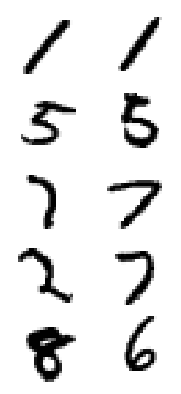

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3,3*batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary",interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size,28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [83]:
y_batch

array([[1],
       [1],
       [1],
       [0],
       [0]])

### training dnn on training set

In [85]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

In [88]:
n_epochs =100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X:X_batch, y:y_batch})
        print(epoch, loss_val)
    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 0.69116664
1 0.5836157
2 0.5113044
3 0.48755524
4 0.4393171
5 0.36573213
6 0.3191264
7 0.29153746
8 0.2656207
9 0.27253282
10 0.3036952
11 0.19442521
12 0.21715713
13 0.2272314
14 0.2066348
15 0.17165475
16 0.17080837
17 0.1411856
18 0.1503245
19 0.190727
20 0.15852079
21 0.15605408
22 0.1448973
23 0.11122693
24 0.104987934
25 0.09493804
26 0.101415396
27 0.11013138
28 0.09986051
29 0.10539369
30 0.09540682
31 0.08981229
32 0.0908608
33 0.101395935
34 0.10147025
35 0.08448343
36 0.058265716
37 0.07271946
38 0.07642804
39 0.09561187
40 0.08845135
41 0.081029296
42 0.04365075
43 0.04338023
44 0.06476116
45 0.08620404
46 0.047895662
47 0.051490594
48 0.055079855
49 0.06668913
50 0.049069505
51 0.06168986
52 0.058157563
53 0.04631531
54 0.04436116
55 0.065743685
56 0.07165797
57 0.074839994
58 0.040168565
59 0.049092088
60 0.02712111
61 0.023271548
62 0.044911526
63 0.034209654
64 0.03973747
65 0.056087054
66 0.034819808
67 0.019295229
68 0.044775672
69 0.021344988
70 0.020953914
71 0.03

### create a new DNN by reusing and freezing the hidden layers of DBB A and adding a softmax ouput layer on top of 10 neurons


In [91]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(frozen_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [95]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.9747
10 Test accuracy: 0.9751
20 Test accuracy: 0.9756
30 Test accuracy: 0.974
40 Test accuracy: 0.9745
50 Test accuracy: 0.9746
60 Test accuracy: 0.9738
70 Test accuracy: 0.9735
80 Test accuracy: 0.9742
90 Test accuracy: 0.9741


In [96]:
# without using transfer learning 
# using DNN trained from scratch

reset_graph()

n_inputs = 28 * 28 
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None,n_inputs), name="X")
y = tf.placeholder(tf.int32,shape=(None), name="y")

dnn_outputs = dnn(X,name="DNN_A")

logits = tf.layers.dense(dnn_outputs,n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits )
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum,use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [98]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")
# accuracy is less compared to the transfer learning model

0 Test accuracy: 0.8694
10 Test accuracy: 0.9276
20 Test accuracy: 0.9296
30 Test accuracy: 0.9398
40 Test accuracy: 0.9411
50 Test accuracy: 0.9415
60 Test accuracy: 0.9421
70 Test accuracy: 0.942
80 Test accuracy: 0.9425
90 Test accuracy: 0.9425
100 Test accuracy: 0.9429
110 Test accuracy: 0.9429
120 Test accuracy: 0.9428
130 Test accuracy: 0.9429
140 Test accuracy: 0.943
